In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

print("="*80)
print("SYSTÈME DE RECOMMANDATION BASÉ SUR LA SIMILARITÉ (KNN)")
print("="*80)


SYSTÈME DE RECOMMANDATION BASÉ SUR LA SIMILARITÉ (KNN)


In [2]:
# ============================================================================
# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES
# ============================================================================

products = pd.read_csv("../Data/olist_products_dataset.csv")
df_order_items = pd.read_csv("../Data/olist_order_items_dataset.csv")
df_order_reviews = pd.read_csv("../Data/olist_order_reviews_dataset.csv")

# Préparation des dates
df_order_items["date"] = pd.to_datetime(df_order_items["shipping_limit_date"])

# Agrégation par produit
product_stats = (
    df_order_items.groupby('product_id')
    .agg(order_count=('order_id', 'count'), avg_price=('price', 'mean'))
    .reset_index()
)

# Fusion des données
reviews_items = df_order_reviews.merge(df_order_items, on='order_id', how='inner')
product_reviews = reviews_items.groupby('product_id').agg({
    'review_score': 'mean',
    'order_item_id': 'count'
}).reset_index()

df_products = product_reviews.merge(products, on='product_id', how='inner')
df_products = df_products.merge(product_stats, on='product_id', how='inner')

print(f"\nNombre total de produits: {len(products['product_id'].unique())}")
print(f"Nombre de produits après fusion: {len(df_products)}")


Nombre total de produits: 32951
Nombre de produits après fusion: 32789


In [3]:

# ============================================================================
# 2. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
# ============================================================================

print("\n" + "="*80)
print("ANALYSE EXPLORATOIRE DES DONNÉES (EDA)")
print("="*80)

# Nettoyage
df_products = df_products.dropna(subset=['product_category_name'])
df_products = df_products.dropna(subset=[
    'product_weight_g', 'product_length_cm', 
    'product_height_cm', 'product_width_cm'
])

# Feature engineering
df_products['volume'] = (
    df_products['product_length_cm'] * 
    df_products['product_height_cm'] * 
    df_products['product_width_cm']
)
df_products['density'] = df_products['product_weight_g'] / (df_products['volume'] + 1)
df_products['popularity_score'] = df_products['order_count'] * df_products['review_score']

print(f"\n📊 Statistiques descriptives:")
print(df_products[['avg_price', 'review_score', 'order_count', 'product_weight_g', 'volume']].describe())
print(f"\nNombre de catégories uniques: {df_products['product_category_name'].nunique()}")
df_products['product_category_name'].isnull().sum()



ANALYSE EXPLORATOIRE DES DONNÉES (EDA)

📊 Statistiques descriptives:
          avg_price  review_score   order_count  product_weight_g  \
count  32183.000000   32183.00000  32183.000000      32183.000000   
mean     145.656320       4.05072      3.444210       2276.839232   
std      243.848540       1.21076     10.675817       4277.637887   
min        0.850000       1.00000      1.000000          0.000000   
25%       39.900000       3.62500      1.000000        300.000000   
50%       79.900000       4.50000      1.000000        700.000000   
75%      155.683333       5.00000      3.000000       1900.000000   
max     6735.000000       5.00000    527.000000      40425.000000   

              volume  
count   32183.000000  
mean    16571.523848  
std     27025.076013  
min       168.000000  
25%      2880.000000  
50%      6859.000000  
75%     18513.000000  
max    296208.000000  

Nombre de catégories uniques: 73


np.int64(0)

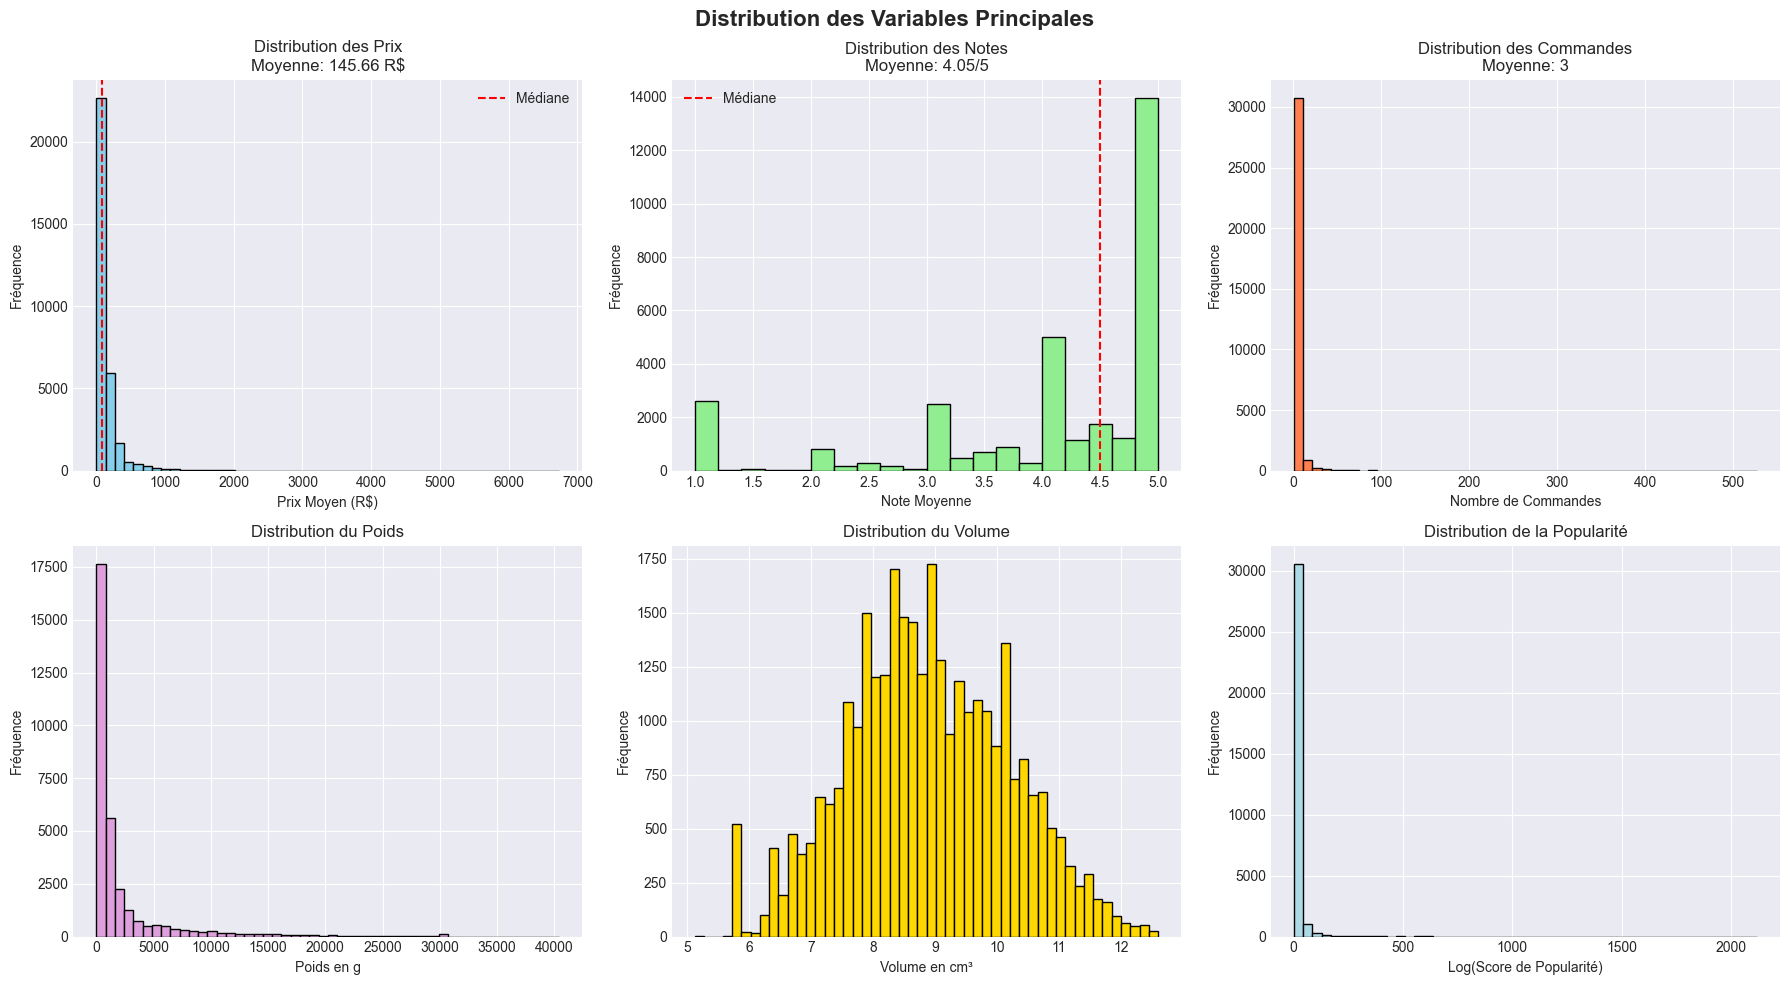

In [172]:

# Visualisation 1: Distribution des variables clés
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution des Variables Principales', fontsize=16, fontweight='bold')

# Prix
axes[0, 0].hist(df_products['avg_price'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Prix Moyen (R$)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title(f'Distribution des Prix\nMoyenne: {df_products["avg_price"].mean():.2f} R$')
axes[0, 0].axvline(df_products['avg_price'].median(), color='red', linestyle='--', label='Médiane')
axes[0, 0].legend()

# Notes
axes[0, 1].hist(df_products['review_score'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Note Moyenne')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title(f'Distribution des Notes\nMoyenne: {df_products["review_score"].mean():.2f}/5')
axes[0, 1].axvline(df_products['review_score'].median(), color='red', linestyle='--', label='Médiane')
axes[0, 1].legend()

# Commandes
axes[0, 2].hist(df_products['order_count'], bins=50, color='coral', edgecolor='black')
axes[0, 2].set_xlabel('Nombre de Commandes')
axes[0, 2].set_ylabel('Fréquence')
axes[0, 2].set_title(f'Distribution des Commandes\nMoyenne: {df_products["order_count"].mean():.0f}')

# Poids
axes[1, 0].hist(df_products['product_weight_g'], bins=50, color='plum', edgecolor='black')
axes[1, 0].set_xlabel('Poids en g')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution du Poids')

# Volume
axes[1, 1].hist(np.log1p(df_products['volume']), bins=50, color='gold', edgecolor='black')
axes[1, 1].set_xlabel('Volume en cm³')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution du Volume')

# Popularité
axes[1, 2].hist(df_products['popularity_score'], bins=50, color='lightblue', edgecolor='black')
axes[1, 2].set_xlabel('Log(Score de Popularité)')
axes[1, 2].set_ylabel('Fréquence')
axes[1, 2].set_title('Distribution de la Popularité')

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()



📊 Matrice de corrélation:
                  avg_price  review_score  order_count  product_weight_g  \
avg_price          1.000000     -0.008827    -0.033025          0.352683   
review_score      -0.008827      1.000000    -0.004302         -0.042029   
order_count       -0.033025     -0.004302     1.000000         -0.013341   
product_weight_g   0.352683     -0.042029    -0.013341          1.000000   
volume             0.307690     -0.041674    -0.015299          0.801272   

                    volume  
avg_price         0.307690  
review_score     -0.041674  
order_count      -0.015299  
product_weight_g  0.801272  
volume            1.000000  


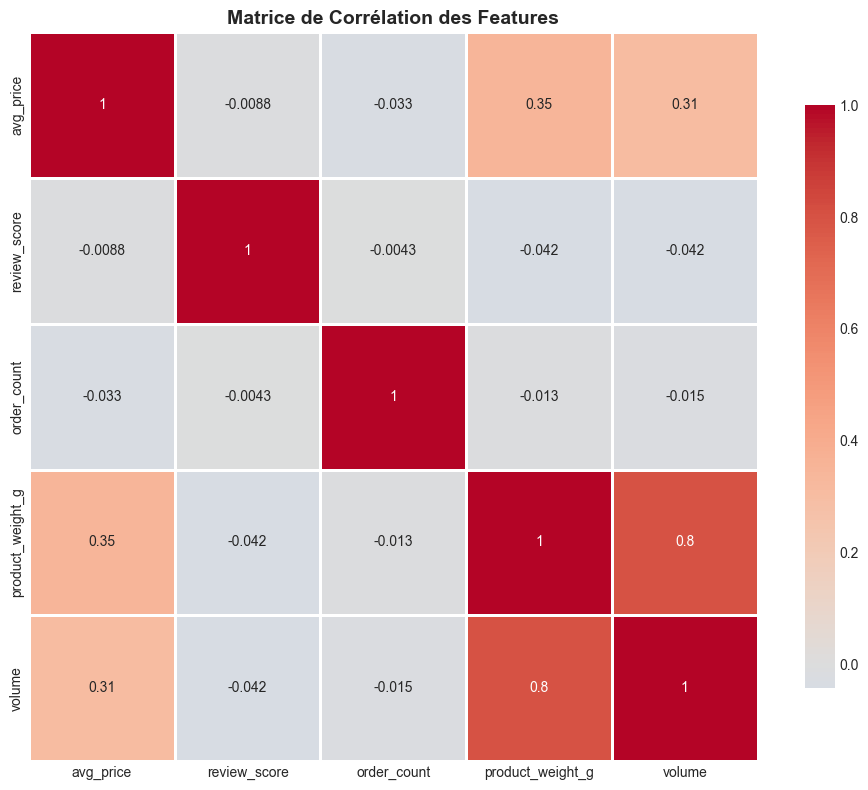


📊 Top 15 Catégories par nombre de produits:
product_category_name
cama_mesa_banho                3009
esporte_lazer                  2855
moveis_decoracao               2638
beleza_saude                   2435
utilidades_domesticas          2325
automotivo                     1892
informatica_acessorios         1637
brinquedos                     1403
relogios_presentes             1321
telefonia                      1125
bebes                           912
perfumaria                      867
fashion_bolsas_e_acessorios     847
papelaria                       846
cool_stuff                      782
Name: count, dtype: int64


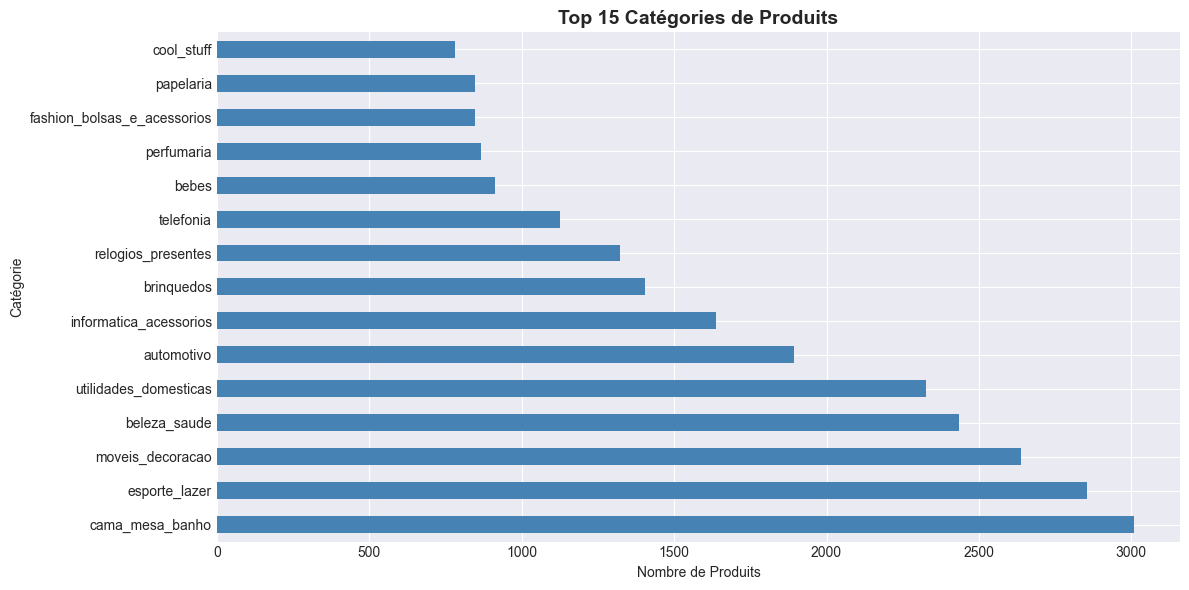

<Figure size 1500x800 with 0 Axes>

In [173]:


# Visualisation 2: Corrélations
print("\n📊 Matrice de corrélation:")
correlation_features = ['avg_price', 'review_score', 'order_count', 'product_weight_g', 'volume']
corr_matrix = df_products[correlation_features].corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualisation 3: Top catégories
print("\n📊 Top 15 Catégories par nombre de produits:")
top_categories = df_products['product_category_name'].value_counts().head(15)
print(top_categories)

plt.figure(figsize=(12, 6))
top_categories.plot(kind='barh', color='steelblue')
plt.xlabel('Nombre de Produits')
plt.ylabel('Catégorie')
plt.title('Top 15 Catégories de Produits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_top_categories.png', dpi=300, bbox_inches='tight')
plt.show()

#

plt.tight_layout()
plt.savefig('eda_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:

# ============================================================================
# 3. PREPROCESSING POUR LE MODÈLE
# ============================================================================

print("\n" + "="*80)
print("PREPROCESSING POUR LE MODÈLE DE RECOMMANDATION")
print("="*80)
df_products['log_order_count'] = np.log1p(df_products['order_count'])
df_products['log_avg_price'] = np.log1p(df_products['avg_price'])

features = [
    'avg_price', 'review_score',
    'product_category_name',
    'volume'
]

num_cols = df_products[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_products[features].select_dtypes(include=['object']).columns.tolist()

print(f"\nColonnes numériques ({len(num_cols)}): {num_cols}")
print(f"Colonnes catégorielles ({len(cat_cols)}): {cat_cols}")

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

X = preprocess.fit_transform(df_products[features])
print(f"\nShape des données transformées: {X.shape}")
print(f"Nombre de features après encoding: {X.shape[1]}")



PREPROCESSING POUR LE MODÈLE DE RECOMMANDATION

Colonnes numériques (3): ['avg_price', 'review_score', 'volume']
Colonnes catégorielles (1): ['product_category_name']

Shape des données transformées: (32183, 76)
Nombre de features après encoding: 76


In [5]:

# ============================================================================
# 4. MODÈLE KNN - NEAREST NEIGHBORS
# ============================================================================

print("\n" + "="*80)
print("CONSTRUCTION DU MODÈLE K-NEAREST NEIGHBORS (KNN)")
print("="*80)

# Test de différentes valeurs de k
k_values = [5]
print("\n🔍 Test de différentes valeurs de k pour KNN:")

for k in k_values:
    knn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    knn.fit(X)
    
    # Calculer la distance moyenne aux k plus proches voisins
    distances, indices = knn.kneighbors(X)
    avg_distance = distances[:, 1:].mean()  # Exclure le produit lui-même
    
    print(f"  k={k:2d} | Distance moyenne aux voisins: {avg_distance:.4f}")

# Choisir k optimal (souvent entre 5 et 10 pour recommandations)
optimal_k = 5
print(f"\n✅ Utilisation de k={optimal_k} pour le modèle final")

knn_model = NearestNeighbors(n_neighbors=optimal_k, metric='cosine', algorithm='brute')
knn_model.fit(X)

# Calculer aussi la matrice de similarité cosinus pour comparaison
similarity_matrix = cosine_similarity(X)
print(f"\nMatrice de similarité calculée: {similarity_matrix.shape}")

# ============================================================================
# 5. ÉVALUATION DU MODÈLE
# ============================================================================

print("\n" + "="*80)
print("ÉVALUATION DU MODÈLE DE RECOMMANDATION")
print("="*80)

# Métrique 1: Distribution des similarités
print("\n📊 Statistiques de similarité globale:")
# Exclure la diagonale (similarité avec soi-même = 1)
mask = ~np.eye(similarity_matrix.shape[0], dtype=bool)
similarities_flat = similarity_matrix[mask]



CONSTRUCTION DU MODÈLE K-NEAREST NEIGHBORS (KNN)

🔍 Test de différentes valeurs de k pour KNN:
  k= 5 | Distance moyenne aux voisins: 0.0053

✅ Utilisation de k=5 pour le modèle final

Matrice de similarité calculée: (32183, 32183)

ÉVALUATION DU MODÈLE DE RECOMMANDATION

📊 Statistiques de similarité globale:


  Similarité moyenne: 0.0475
  Similarité médiane: 0.0507
  Écart-type: 0.3449
  Min: -0.7288
  Max: 1.0000


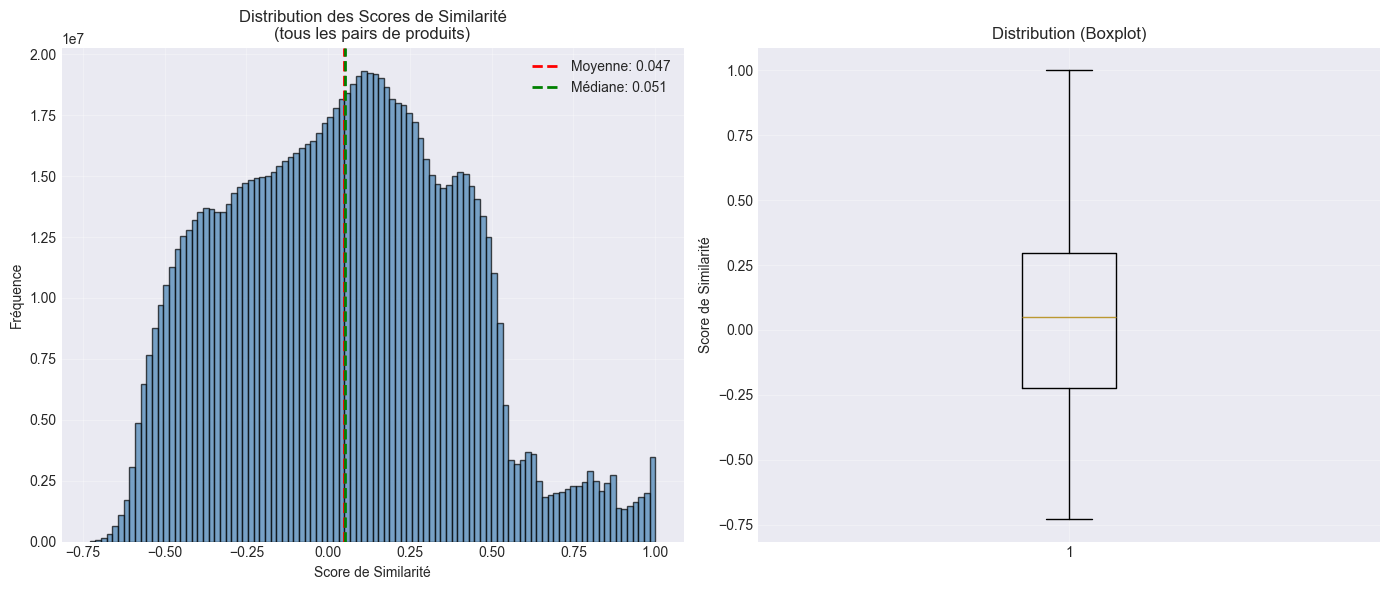

In [6]:

print(f"  Similarité moyenne: {similarities_flat.mean():.4f}")
print(f"  Similarité médiane: {np.median(similarities_flat):.4f}")
print(f"  Écart-type: {similarities_flat.std():.4f}")
print(f"  Min: {similarities_flat.min():.4f}")
print(f"  Max: {similarities_flat.max():.4f}")

# Visualisation de la distribution des similarités
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(similarities_flat, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Score de Similarité')
plt.ylabel('Fréquence')
plt.title('Distribution des Scores de Similarité\n(tous les pairs de produits)')
plt.axvline(similarities_flat.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {similarities_flat.mean():.3f}')
plt.axvline(np.median(similarities_flat), color='green', linestyle='--', linewidth=2, label=f'Médiane: {np.median(similarities_flat):.3f}')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(similarities_flat, vert=True)
plt.ylabel('Score de Similarité')
plt.title('Distribution (Boxplot)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_similarity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
import numpy as np

K = 5  # nombre de voisins recommandés
topk_similarities = []

for i in range(len(X)):
    distances, indices = knn_model.kneighbors(X[i].reshape(1, -1))
    
    # Exclure le produit lui-même (distance = 0)
    neighbor_distances = distances[0][1:]
    
    # Cosine similarity = 1 - cosine distance
    similarities = 1 - neighbor_distances
    
    topk_similarities.extend(similarities)

topk_similarities = np.array(topk_similarities)

print("\n📊 Statistiques de similarité TOP-K :")
print(f"  Similarité moyenne:  {topk_similarities.mean():.4f}")
print(f"  Similarité médiane:  {np.median(topk_similarities):.4f}")
print(f"  Écart-type:          {topk_similarities.std():.4f}")
print(f"  Min:                {topk_similarities.min():.4f}")
print(f"  Max:                {topk_similarities.max():.4f}")



📊 Statistiques de similarité TOP-K :
  Similarité moyenne:  0.9947
  Similarité médiane:  0.9993
  Écart-type:          0.0183
  Min:                0.1625
  Max:                1.0000



📊 Évaluation de la cohérence catégorielle:
(Les produits similaires sont-ils de la même catégorie?)

  Score moyen de cohérence catégorielle: 98.78%
  (98.8% des voisins sont de la même catégorie en moyenne)


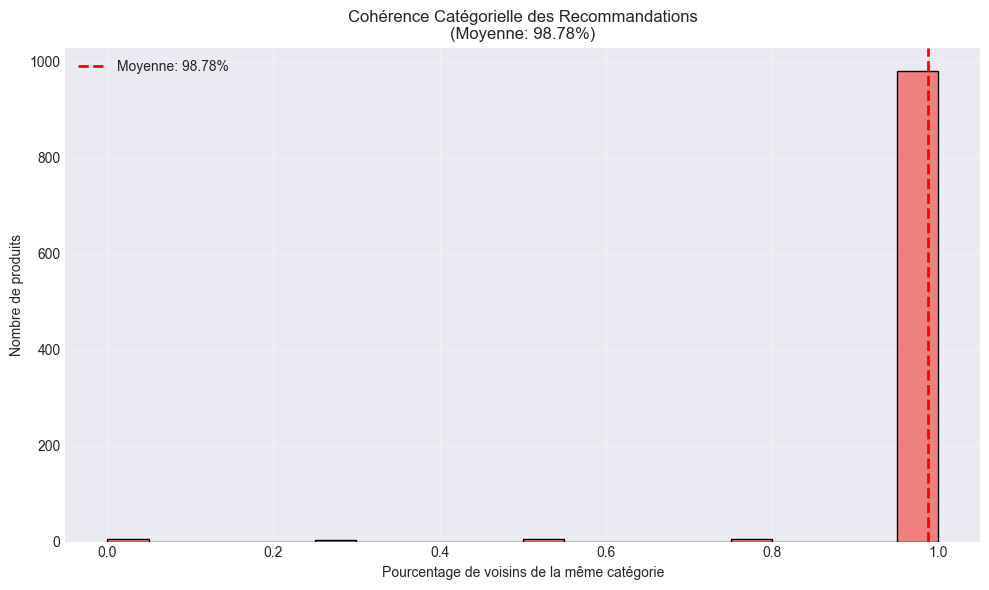


📊 Évaluation de la diversité des prix:

  Coefficient de variation moyen des prix: 0.137
  (Plus élevé = plus de diversité dans les prix recommandés)

📊 Évaluation de la couverture (Coverage):

  Couverture du catalogue: 11.62%
  (3741 produits sur 32183 sont recommandés au moins une fois)


In [8]:

# Métrique 2: Cohérence catégorielle
print("\n📊 Évaluation de la cohérence catégorielle:")
print("(Les produits similaires sont-ils de la même catégorie?)")

category_match_scores = []
sample_size = min(1000, len(df_products))
sample_indices = np.random.choice(len(df_products), sample_size, replace=False)

for idx in sample_indices:
    # Trouver les k plus proches voisins
    distances, indices = knn_model.kneighbors(X[idx].reshape(1, -1))
    neighbor_indices = indices[0][1:]  # Exclure le produit lui-même
    
    # Vérifier si les voisins sont de la même catégorie
    source_category = df_products.iloc[idx]['product_category_name']
    neighbor_categories = df_products.iloc[neighbor_indices]['product_category_name'].values
    
    matches = (neighbor_categories == source_category).sum()
    category_match_scores.append(matches / len(neighbor_categories))

avg_category_match = np.mean(category_match_scores)
print(f"\n  Score moyen de cohérence catégorielle: {avg_category_match:.2%}")
print(f"  ({avg_category_match*100:.1f}% des voisins sont de la même catégorie en moyenne)")

plt.figure(figsize=(10, 6))
plt.hist(category_match_scores, bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Pourcentage de voisins de la même catégorie')
plt.ylabel('Nombre de produits')
plt.title(f'Cohérence Catégorielle des Recommandations\n(Moyenne: {avg_category_match:.2%})')
plt.axvline(avg_category_match, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {avg_category_match:.2%}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('evaluation_category_coherence.png', dpi=300, bbox_inches='tight')
plt.show()

# Métrique 3: Diversité des prix dans les recommandations
print("\n📊 Évaluation de la diversité des prix:")

price_diversity_scores = []
for idx in sample_indices:
    distances, indices = knn_model.kneighbors(X[idx].reshape(1, -1))
    neighbor_indices = indices[0][1:]
    
    source_price = df_products.iloc[idx]['avg_price']
    neighbor_prices = df_products.iloc[neighbor_indices]['avg_price'].values
    
    # Coefficient de variation (std/mean) des prix
    price_std = neighbor_prices.std()
    price_mean = neighbor_prices.mean()
    cv = price_std / price_mean if price_mean > 0 else 0
    
    price_diversity_scores.append(cv)

avg_price_diversity = np.mean(price_diversity_scores)
print(f"\n  Coefficient de variation moyen des prix: {avg_price_diversity:.3f}")
print(f"  (Plus élevé = plus de diversité dans les prix recommandés)")

# Métrique 4: Coverage - Combien de produits sont recommandés au moins une fois?
print("\n📊 Évaluation de la couverture (Coverage):")

recommended_products = set()
for idx in sample_indices:
    distances, indices = knn_model.kneighbors(X[idx].reshape(1, -1))
    neighbor_indices = indices[0][1:]
    recommended_products.update(neighbor_indices)

coverage = len(recommended_products) / len(df_products)
print(f"\n  Couverture du catalogue: {coverage:.2%}")
print(f"  ({len(recommended_products)} produits sur {len(df_products)} sont recommandés au moins une fois)")



VISUALISATION DE L'ESPACE DES PRODUITS (PCA)

Variance expliquée par PC1: 33.26%
Variance expliquée par PC2: 25.28%
Variance totale expliquée: 58.54%


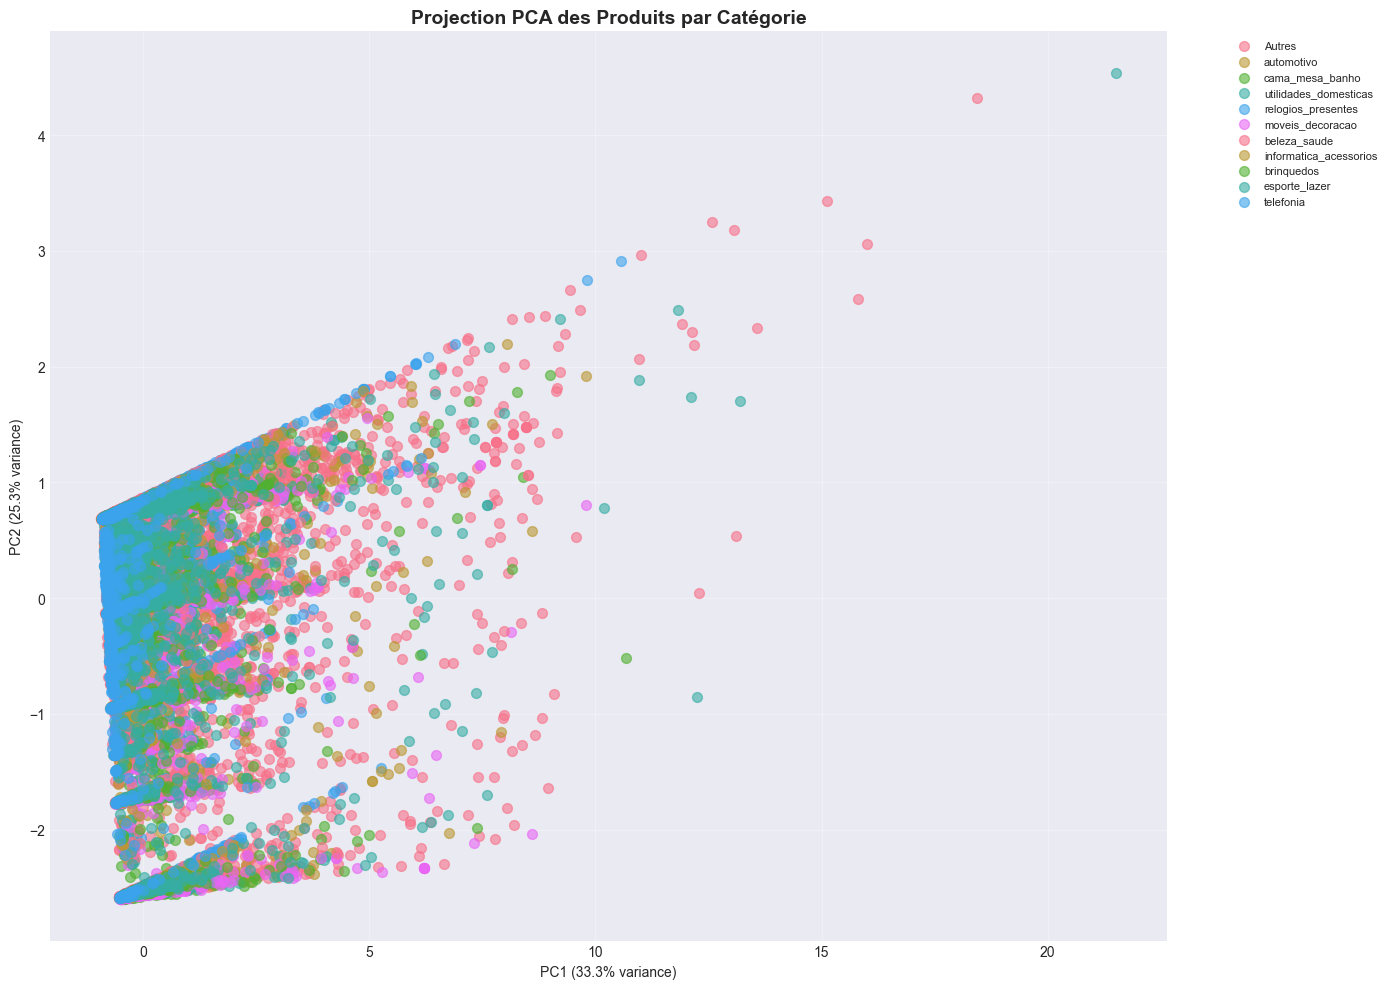

In [9]:

# ============================================================================
# 6. VISUALISATION PCA
# ============================================================================

print("\n" + "="*80)
print("VISUALISATION DE L'ESPACE DES PRODUITS (PCA)")
print("="*80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(f"\nVariance expliquée par PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance expliquée par PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Variance totale expliquée: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Visualisation avec couleurs par catégorie (top catégories)
top_n_categories = 10
top_cat_list = df_products['product_category_name'].value_counts().head(top_n_categories).index.tolist()
df_products['category_group'] = df_products['product_category_name'].apply(
    lambda x: x if x in top_cat_list else 'Autres'
)

plt.figure(figsize=(14, 10))
for category in df_products['category_group'].unique():
    mask = df_products['category_group'] == category
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=category, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Projection PCA des Produits par Catégorie', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('evaluation_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:

# ============================================================================
# 7. EXEMPLE DE RECOMMANDATION AVEC ÉVALUATION
# ============================================================================

print("\n" + "="*80)
print("EXEMPLE DE RECOMMANDATION AVEC ÉVALUATION DÉTAILLÉE")
print("="*80)

# Choisir un produit exemple
sample_idx = 200
sample_product = df_products.iloc[sample_idx]

print(f"\n🎯 PRODUIT SOURCE:")
print(f"  ID: {sample_product['product_id']}")
print(f"  Catégorie: {sample_product['product_category_name']}")
print(f"  Prix: {sample_product['avg_price']:.2f} R$")
print(f"  Note: {sample_product['review_score']:.2f}/5")
print(f"  Commandes: {int(sample_product['order_count'])}")

# Obtenir les recommandations
distances, indices = knn_model.kneighbors(X[sample_idx].reshape(1, -1))
neighbor_indices = indices[0][1:]  # Exclure le produit lui-même
neighbor_distances = distances[0][1:]

print(f"\n📦 TOP {optimal_k-1} RECOMMANDATIONS:")
for i, (idx, dist) in enumerate(zip(neighbor_indices, neighbor_distances), 1):
    rec_product = df_products.iloc[idx]
    similarity = 1 - dist  # Convertir distance cosinus en similarité
    
    print(f"\n{i}. Similarité: {similarity:.3f}")
    print(f"   ID: {rec_product['product_id']}")
    print(f"   Catégorie: {rec_product['product_category_name']}")
    print(f"   Prix: {rec_product['avg_price']:.2f} R$ (Δ: {rec_product['avg_price'] - sample_product['avg_price']:+.2f})")
    print(f"   Note: {rec_product['review_score']:.2f}/5")
    print(f"   Commandes: {int(rec_product['order_count'])}")



EXEMPLE DE RECOMMANDATION AVEC ÉVALUATION DÉTAILLÉE

🎯 PRODUIT SOURCE:
  ID: 019003324f0a201dd2c8962beaf94b6d
  Catégorie: livros_importados
  Prix: 64.99 R$
  Note: 5.00/5
  Commandes: 1

📦 TOP 4 RECOMMANDATIONS:

1. Similarité: 1.000
   ID: 97de49733ccaac64d122444d8db709d1
   Catégorie: livros_importados
   Prix: 64.99 R$ (Δ: +0.00)
   Note: 5.00/5
   Commandes: 1

2. Similarité: 1.000
   ID: 81fe540cb0119e1d4ef5f191701b3cb9
   Catégorie: livros_importados
   Prix: 63.00 R$ (Δ: -1.99)
   Note: 5.00/5
   Commandes: 2

3. Similarité: 1.000
   ID: fde71f25e699ca0a2a83a6c3a249b816
   Catégorie: livros_importados
   Prix: 61.00 R$ (Δ: -3.99)
   Note: 5.00/5
   Commandes: 3

4. Similarité: 1.000
   ID: 975c79322e3ae1a967d8f5b82608ffd7
   Catégorie: livros_importados
   Prix: 69.00 R$ (Δ: +4.01)
   Note: 5.00/5
   Commandes: 1


# ============================================================================
# 8. SAUVEGARDE DU MODÈLE POUR PRODUCTION
# ============================================================================

In [11]:
import pickle
import os
import json
from datetime import datetime

# Créer le dossier pour les modèles s'il n'existe pas
model_dir = "../streamlit_app/models/recommendation"
os.makedirs(model_dir, exist_ok=True)

print("💾 Sauvegarde du modèle de recommandation...")

# 1. Sauvegarder le modèle KNN
model_path = os.path.join(model_dir, "knn_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(knn_model, f)
print(f"✅ Modèle KNN sauvegardé: {model_path}")

# 2. Sauvegarder le preprocessor
preprocessor_path = os.path.join(model_dir, "preprocessor.pkl")
with open(preprocessor_path, 'wb') as f:
    pickle.dump(preprocess, f)
print(f"✅ Preprocessor sauvegardé: {preprocessor_path}")

# 3. Sauvegarder la matrice des features transformées
features_path = os.path.join(model_dir, "features_matrix.pkl")
with open(features_path, 'wb') as f:
    pickle.dump(X, f)
print(f"✅ Matrice des features sauvegardée: {features_path}")

# 4. Sauvegarder le DataFrame des produits (avec toutes les features)
products_path = os.path.join(model_dir, "products_data.pkl")
df_products.to_pickle(products_path)
print(f"✅ DataFrame des produits sauvegardé: {products_path}")

# 5. Sauvegarder les colonnes de features utilisées
features_info = {
    'numeric_columns': num_cols,
    'categorical_columns': cat_cols,
    'all_features': features,
    'k_neighbors': optimal_k
}
features_path_json = os.path.join(model_dir, "features_info.json")
with open(features_path_json, 'w') as f:
    json.dump(features_info, f, indent=2)
print(f"✅ Informations des features sauvegardées: {features_path_json}")

print("\n✨ Sauvegarde terminée avec succès!")

💾 Sauvegarde du modèle de recommandation...
✅ Modèle KNN sauvegardé: ../streamlit_app/models/recommendation\knn_model.pkl
✅ Preprocessor sauvegardé: ../streamlit_app/models/recommendation\preprocessor.pkl
✅ Matrice des features sauvegardée: ../streamlit_app/models/recommendation\features_matrix.pkl
✅ DataFrame des produits sauvegardé: ../streamlit_app/models/recommendation\products_data.pkl
✅ Informations des features sauvegardées: ../streamlit_app/models/recommendation\features_info.json

✨ Sauvegarde terminée avec succès!


In [12]:
# 6. Sauvegarder les métadonnées et métriques
config = {
    "model_name": "KNN Product Recommendation",
    "model_type": "clustering",
    "trained_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "n_products": len(df_products),
    "n_features": X.shape[1],
    "k_neighbors": optimal_k,
    "metric": "cosine",
    "algorithm": "brute",
    
    # Métriques d'évaluation
    "metrics": {
        "avg_similarity": float(similarities_flat.mean()),
        "median_similarity": float(np.median(similarities_flat)),
        "category_coherence": float(avg_category_match),
        "catalog_coverage": float(coverage),
        "topk_avg_similarity": float(topk_similarities.mean())
    },
    
    # Informations sur les données
    "data_info": {
        "n_categories": int(df_products['product_category_name'].nunique()),
        "avg_price": float(df_products['avg_price'].mean()),
        "avg_review_score": float(df_products['review_score'].mean()),
        "avg_order_count": float(df_products['order_count'].mean())
    },
    
    # Features utilisées
    "features": {
        "numeric": num_cols,
        "categorical": cat_cols
    }
}

config_path = os.path.join(model_dir, "config.json")
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print(f"✅ Configuration et métriques sauvegardées: {config_path}")

# Afficher un résumé
print("\n📊 RÉSUMÉ DU MODÈLE SAUVEGARDÉ:")
print(f"  • Nombre de produits: {config['n_products']}")
print(f"  • Nombre de features: {config['n_features']}")
print(f"  • K voisins: {config['k_neighbors']}")
print(f"  • Similarité moyenne: {config['metrics']['avg_similarity']:.4f}")
print(f"  • Cohérence catégorielle: {config['metrics']['category_coherence']:.2%}")
print(f"  • Couverture du catalogue: {config['metrics']['catalog_coverage']:.2%}")

✅ Configuration et métriques sauvegardées: ../streamlit_app/models/recommendation\config.json

📊 RÉSUMÉ DU MODÈLE SAUVEGARDÉ:
  • Nombre de produits: 32183
  • Nombre de features: 76
  • K voisins: 5
  • Similarité moyenne: 0.0475
  • Cohérence catégorielle: 98.78%
  • Couverture du catalogue: 11.62%
